/mnt/c/Users/cltng/OneDrive/chatgpt/dev_nbs


In [16]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output

import gymnasium as gym
import torch
import numpy as np
from collections import defaultdict
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure
tensorboard_log = './ppotb'
device='cpu'
inbred_parent_data = np.load('../nbs/data/g2f_ch10.npy', allow_pickle=True)

@dataclass
class SimulationConfig:
    n_markers: int = 1000
    starting_parents: int = 20
    pop_size: int = 1000
    h2: float = 1.0
    sparse_reward: bool = True

class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, haplotypes:torch.tensor, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.haplotypes: torch.Tensor = haplotypes
        self.device: torch.device = device
        



    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"




class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1.0):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        raw_effects = torch.randn(genome.n_markers, device=self.device)
        centered_effects = raw_effects - raw_effects.mean()
        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()

    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"

class SimOps:
    @staticmethod
    def score_population(population: Population, trait: Trait, h2: float = 1.0) -> torch.Tensor:
        dosages = population.haplotypes.sum(dim=1)
        breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)

        bv_var = breeding_values.var()
        if bv_var == 0 or h2 >= 1:
            return breeding_values

        env_variance = (1 - h2) / h2 * bv_var.item()
        env_std = torch.sqrt(torch.tensor(env_variance, device=population.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        return breeding_values + env_effects + trait.intercept


    @staticmethod
    def truncation_selection(population: Population, phenotypes: torch.Tensor, selection_intensity: float, return_indices: bool = False) -> torch.Tensor:
        assert 0 < selection_intensity <= 1, "Selection intensity must be between 0 and 1"
        assert population.haplotypes.shape[0] == phenotypes.shape[0], "Mismatch between population size and phenotypes"
        num_select = max(1, min(int(selection_intensity * population.pop_size), population.pop_size - 1))
        _, top_indices = torch.topk(phenotypes, num_select)
        if return_indices:
            return top_indices
        return population.haplotypes[top_indices]


    @staticmethod
    def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        num_parents, ploidy, num_markers = selected_haplotypes.shape

        # Repeat each parent's haplotypes num_gametes_per_parent times
        expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)

        # The rest of the function remains largely the same, but operates on the expanded haplotypes
        total_gametes = num_parents * num_gametes_per_parent

        crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device)
        crossover_points, _ = torch.sort(crossover_points, dim=1)

        crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
        crossover_mask.scatter_(1, crossover_points, 1)
        crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1

        crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)

        start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
        start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)

        final_mask = crossover_mask ^ start_mask.bool()

        offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))

        # Return only the first haplotype for each meiosis event
        return offspring_haplotypes[:, 0, :]
    @staticmethod
    def check_cuda(tensor: torch.Tensor, name: str) -> None:
        print(f"{name} is on: {tensor.device}")


    @staticmethod
    def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
        num_gametes, n_markers = gamete_tensor.shape

        # Double the gamete tensor until we have enough for the total crosses
        while num_gametes < 2 * total_crosses:
            gamete_tensor = torch.cat([gamete_tensor, gamete_tensor], dim=0)
            num_gametes *= 2

        # Randomly select gametes for crossing
        gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
        parent1_indices = gamete_indices[:total_crosses]
        parent2_indices = gamete_indices[total_crosses:2*total_crosses]

        # Create the new population haplotype tensor
        new_population = torch.stack([
            gamete_tensor[parent1_indices],
            gamete_tensor[parent2_indices]
        ], dim=1)

        return new_population
    
def grab_inbred_parents(starting_parents, genome, device=device):

        inbred_data = inbred_parent_data
        
        if starting_parents > inbred_data.shape[0]:
            raise ValueError("Total parents requested exceed the number of available parents.")
        if genome.n_markers > inbred_data.shape[2]:
            raise ValueError("Total markers requested exceed the number of available markers.")
        # Randomly sample parents
        sampled_parents_indices = np.random.choice(inbred_data.shape[0], starting_parents, replace=False)
        sampled_parents = inbred_data[sampled_parents_indices, :, :]
        # Randomly sample markers
        sampled_markers_indices = np.random.choice(inbred_data.shape[2], genome.n_markers, replace=False)
        return torch.tensor(sampled_parents[:, :, sampled_markers_indices], device=device).float()

##################

class SimParams:
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.genome = Genome(config.n_markers)
        self.population = Population(config.pop_size, grab_inbred_parents(5,self.genome), self.genome,device)
        f1 = self.perform_meiosis(self.population.haplotypes, num_crossovers=3, num_gametes_per_parent=((2000//self.population.haplotypes.shape[0]) *self.population.haplotypes.shape[0] + 100))
        self.create_next_generation(f1, total_crosses=2000)
        num_gametes_per_parent = (self.population.haplotypes.shape[0] / config.pop_size) + 2 
        segregating_pop = self.perform_meiosis(self.population.haplotypes, num_crossovers=3, num_gametes_per_parent=100)
        self.create_next_generation(segregating_pop, total_crosses=config.pop_size)

        
        self.trait = Trait(self.genome, self.population)


    def score_population(self, h2: Optional[float] = None) -> torch.Tensor:
        h2 = h2 if h2 is not None else self.config.h2
        return SimOps.score_population(self.population, self.trait, h2)

    def truncation_selection(self, selection_intensity: Optional[float] = None, phenotypes: Optional[torch.Tensor] = None, return_indices: bool = False) -> torch.Tensor:
        selection_intensity = selection_intensity if selection_intensity is not None else self.config.selection_intensity
        if phenotypes is None:
            phenotypes = self.score_population()
        return SimOps.truncation_selection(self.population, phenotypes, selection_intensity, return_indices)

    def check_device(self) -> None:
        SimOps.check_cuda(self.population.haplotypes, "Population haplotypes")
        SimOps.check_cuda(self.trait.effects, "Trait effects")
        SimOps.check_cuda(self.trait.intercept, "Trait intercept")

    def to(self, device: torch.device) -> 'SimParams':
        self.device = device
        self.population = self.population.to(device)
        self.trait = self.trait.to(device)
        return self
    def perform_meiosis(self, selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        return SimOps.meiosis(selected_haplotypes, num_crossovers, num_gametes_per_parent)

    def create_next_generation(self, gametes: torch.Tensor, total_crosses: int) -> None:
        new_population_haplotypes = SimOps.random_cross(gametes, total_crosses)
        # assert new_population_haplotypes.shape[0] == self.config.pop_size, "Population size changed unexpectedly"
        self.population.haplotypes = new_population_haplotypes
        self.population.pop_size = total_crosses


import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import gymnasium as gym
import torch

import numpy as np
import gymnasium as gym
import torch

class SelectionIntensityEnvironment(gym.Env):
    def __init__(self, SP, config, max_generations=10):
        super(SelectionIntensityEnvironment, self).__init__()
        self.SP = SP
        self.config = config
        self.max_generations = max_generations
        self.current_generation = 0
        self.founder_population = self.SP.population.haplotypes
        self.action_space = gym.spaces.Box(low=0.01, high=0.99, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Dict({
            "generation_percent_remaining": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "genetic_var": gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            "selection_differential": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            "average_episode_actions": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "inbreeding_coefficient": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
        })
        self.current_population = self.SP.population.haplotypes.clone()
        self.phenotypes = self.SP.score_population()
        self.action_history = []
        self.inbreeding_coefficient = self.calculate_inbreeding_coefficient()
        self.last_selected_phenotypes = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.SP.population.haplotypes = self.founder_population.clone()
        self.phenotypes = self.SP.score_population()
        self.action_history = []
        self.inbreeding_coefficient = self.calculate_inbreeding_coefficient()
        self.last_selected_phenotypes = None
        return self._get_observation(), {}

    def _get_observation(self):
        return {
            "generation_percent_remaining": np.array([(self.max_generations - self.current_generation) / self.max_generations], dtype=np.float32),
            "genetic_var": np.array([self.phenotypes.var().item()], dtype=np.float32),
            "selection_differential": np.array([self.calculate_selection_differential()], dtype=np.float32),
            "average_episode_actions": np.array([np.mean(self.action_history) if self.action_history else 0], dtype=np.float32),
            "inbreeding_coefficient": np.array([self.inbreeding_coefficient], dtype=np.float32),
        }

    def calculate_inbreeding_coefficient(self):
        heterozygosity = (self.SP.population.haplotypes[:, 0, :] != self.SP.population.haplotypes[:, 1, :]).float().mean()
        inbreeding_coeff = 1 - (heterozygosity / 0.5)
        return inbreeding_coeff.item()

    def calculate_selection_differential(self):
        if self.last_selected_phenotypes is None:
            return 0
        return (self.last_selected_phenotypes.mean() - self.phenotypes.mean()).item()

    def step(self, action):
        selection_intensity = action[0]
        self.action_history.append(selection_intensity)
        self.selection_differential = self.calculate_selection_differential()
        selected_indices = self.SP.truncation_selection(selection_intensity, self.phenotypes, return_indices=True)
        self.last_selected_phenotypes = self.phenotypes[selected_indices]
        selected_haplotypes = self.SP.population.haplotypes[selected_indices]
        
        total_crosses = self.config.pop_size
        total_gametes_needed = total_crosses * 2
        num_parents = selected_haplotypes.shape[0]
        num_gametes_per_parent = -(-total_gametes_needed // num_parents) + 2
        
        gametes = self.SP.perform_meiosis(selected_haplotypes, num_crossovers=3, num_gametes_per_parent=num_gametes_per_parent)
        self.SP.create_next_generation(gametes, total_crosses)
        self.phenotypes = self.SP.score_population()
        self.inbreeding_coefficient = self.calculate_inbreeding_coefficient()
        self.current_generation += 1

        done = self.current_generation >= self.max_generations

        if self.config.sparse_reward:
            reward = float(self.phenotypes.max().item()) if done else 0.0
        else:
            reward = float(self.phenotypes.max().item())

        observation = self._get_observation()
        info = {
            'max_phenotype': float(self.phenotypes.max().item()),
            'genetic_variance': float(self.phenotypes.var().item()),
            'selection_intensity': float(action[0]),
            'selection_differential': self.selection_differential,
            'current_generation': self.current_generation,
            'inbreeding_coefficient': self.inbreeding_coefficient,
        }

        return observation, reward, done, False, info

    
    
    
    
    
    
    
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from IPython.display import clear_output

class GeneralizedVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0, log_freq=100):
        super().__init__(verbose)
        self.data = defaultdict(lambda: defaultdict(list))
        self.log_freq = log_freq
        self.excluded_metrics = ['TimeLimit.truncated', 'current_generation']

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        obs = self.locals['new_obs']
        
        current_generation = info['current_generation']
        
        # Track all scalar values from the observation space
        for key, value in obs.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)
        
        # Also track any scalar values from the info dict
        for key, value in info.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)

        if self.num_timesteps % self.log_freq == 0:
            self.visualize()

        return True

    def visualize(self):
        num_metrics = len(self.data)
        fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 6*num_metrics), sharex=True)
        if num_metrics == 1:
            axes = [axes]
        
        for idx, (metric, generations) in enumerate(self.data.items()):
            ax = axes[idx]
            for generation, values in generations.items():
                steps = np.arange(len(values))
                avg_values = np.cumsum(values) / (np.arange(len(values)) + 1)
                ax.plot(steps, avg_values, label=f'Generation {generation}')
            
            ax.set_title(f'Average {metric.capitalize()} by Generation')
            ax.set_ylabel(f'Average {metric.capitalize()}')
            ax.legend()
            ax.grid(True)
        
        axes[-1].set_xlabel('Steps within Generation')
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()
    
    
    
    
    
    
    
total_timesteps= 100000
max_generations = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have already defined your environment
config = SimulationConfig(n_markers=50, pop_size=100, h2=1.0, starting_parents=1)
SP = SimParams(config)
env =  SelectionIntensityEnvironment(SP, config, max_generations=max_generations)

# Set up the environment

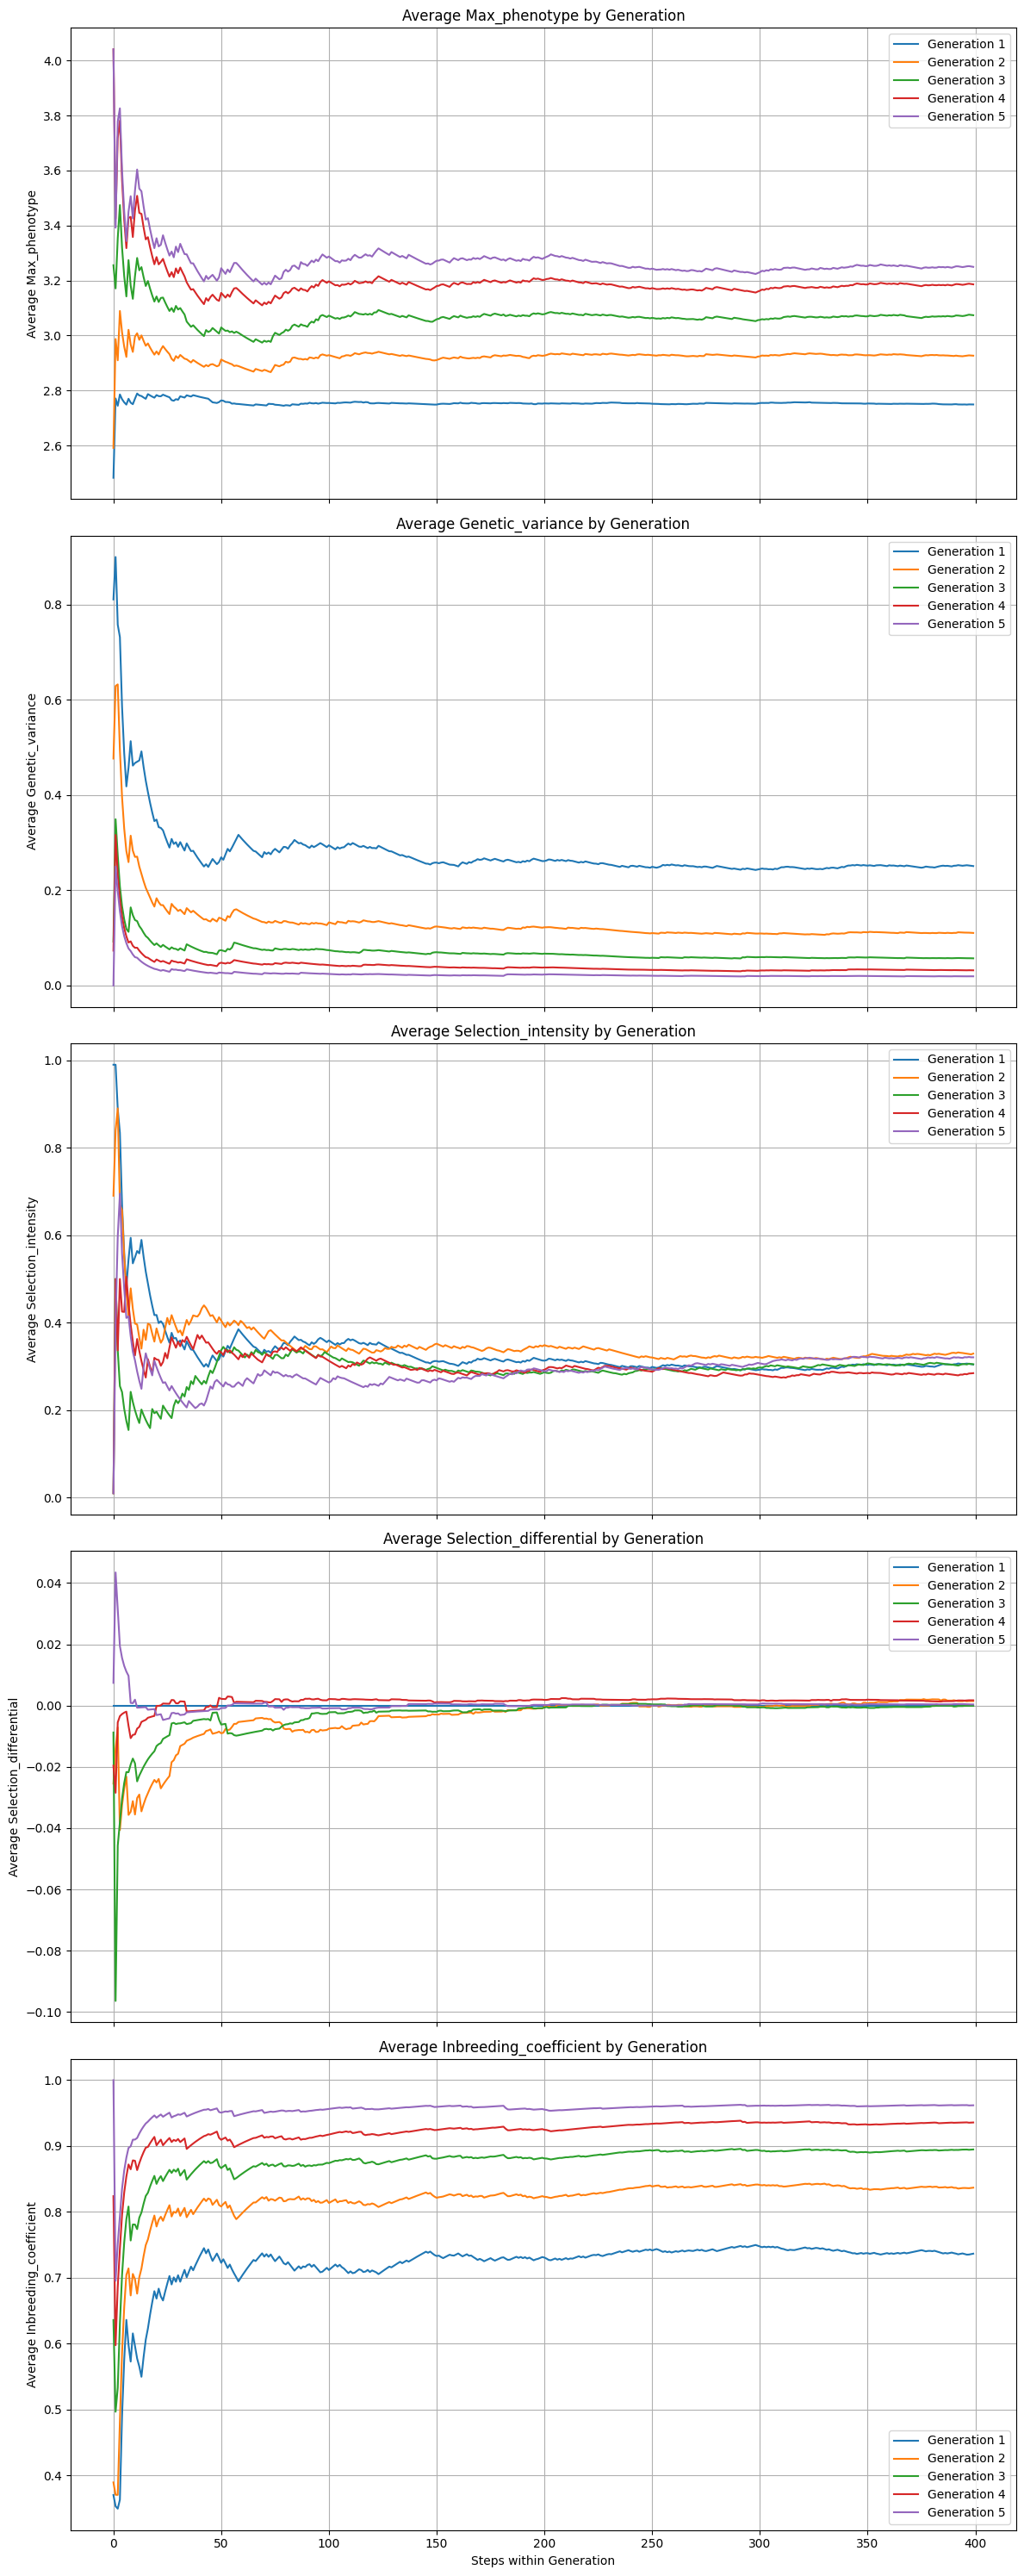

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | 3.31     |
| time/              |          |
|    fps             | 437      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------


In [ ]:
# Set up the environment
config = SimulationConfig(n_markers=50, pop_size=100, h2=1.0, starting_parents=1)
SP = SimParams(config)
env = SelectionIntensityEnvironment(SP, config, max_generations=max_generations)

# Set up the model and callback
model = PPO("MultiInputPolicy", env, device='cuda', verbose=1, tensorboard_log=tensorboard_log)
vis_callback = GeneralizedVisualizationCallback(log_freq=1000)  # Adjust log_freq as needed

# Train the model
model.learn(total_timesteps=total_timesteps, callback=vis_callback)